# Boson Sampling

We are interested to simulate a boson sample with 14 photons and 60 modes, order of size comparable to what was done in *Boson Sampling with 20 Input Photons and a 60-Mode Interferometer in a* $10^{14}$*-Dimensional Hilbert Space* <a href="#references">[1]</a>

In [1]:
from collections import Counter
import gzip
import pickle
import time

import random

import perceval as pcvl
from perceval.algorithm import Sampler

We define all the needed values below. 

## Perfect Boson sampling

In [7]:
n = 3       #number of photons at the input
m = 4    #number of modes
N = 5000  #number of samplings

### Generating a Haar random Unitary with Perceval

In [8]:
Unitary_60 = pcvl.Matrix.random_unitary(m) #creates a random unitary of dimension 60

### A possible linear circuit realization of such matrix would be the following.

Here we define a 2-mode unitary circuit that we can use to decompose the 60 mode unitary

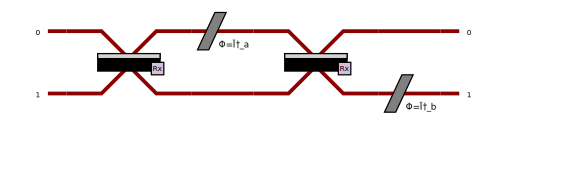

In [9]:
mzi = (pcvl.BS() // (0, pcvl.PS(phi=pcvl.Parameter("Ï†_a")))
       // pcvl.BS() // (1, pcvl.PS(phi=pcvl.Parameter("Ï†_b"))))
pcvl.pdisplay(mzi)

Let us decompose the unitary into a Reck's type circuit <a href="#references">[2]</a> - this makes a huge circuit...

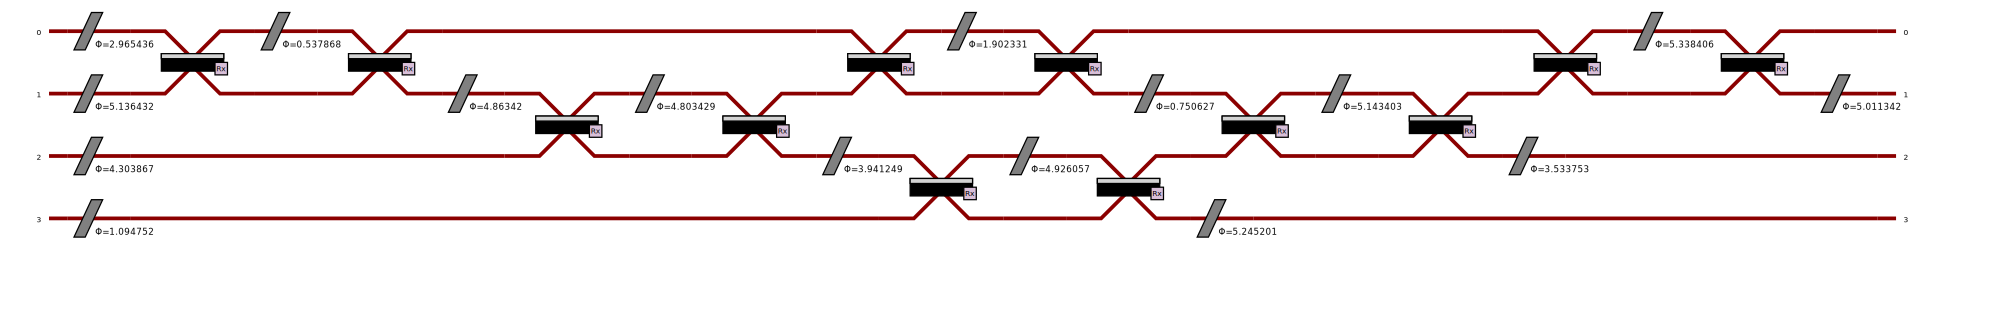

In [10]:
Linear_Circuit_60 = pcvl.Circuit.decomposition(Unitary_60, mzi,
                                               phase_shifter_fn=pcvl.PS,
                                               shape="triangle")

pcvl.pdisplay(Linear_Circuit_60)

### Running Simulation

Now we choose the way to perform the simulation with Perceval. The number of photons is within what we could simulate with a `Naive` backend (see [here](https://perceval.quandela.net/docs/backends.html#naive)), however, the output space is far too big just to enumerate and store the states - so let us go with sampling using `CliffordClifford2017` backend (see [here](https://perceval.quandela.net/docs/backends.html#cliffordclifford2017)).

In [11]:
QPU = pcvl.Processor("CliffordClifford2017", Linear_Circuit_60)

Select a random input:

In [15]:
#one can choose which mode he/she wants at input, or we can choose it randomly 
def Generating_Input(n, m, modes = None):
    "This function randomly chooses an input with n photons in m modes."
    if modes == None :
        modes = sorted(random.sample(range(m),n))
    state = "|"
    for i in range(m):
        state = state + "0"*(1 - (i in modes)) +"1"*(i in modes)+ ","*(i < m-1)
    return pcvl.BasicState(state + ">")

input_state = Generating_Input(n, m)
print("The input state: ", input_state)
QPU.with_input(input_state)

The input state:  |0,1,1,1>


Just to see that it outputs a statevectors of n photon(s) in m modes.

In [16]:
# Keep all outputs
QPU.mode_post_selection(0)

sampler = Sampler(QPU)

print("The sampled outputs are:")
for out_state in sampler.samples(10)["results"]:
    print(out_state)

The sampled outputs are:
|2,0,1,0>
|2,0,1,0>
|1,2,0,0>
|0,1,0,2>
|1,2,0,0>
|0,2,0,1>
|1,2,0,0>
|3,0,0,0>
|1,0,0,2>
|0,0,1,2>


We carry out the sampling, we do it N times, it will take some time, let us save the results to a file:

In [17]:
# if we want to launch parallel process
worker_id=1

#store the input and the unitary
with open("%dphotons_%dmodes_%dsamples-worker%s-unitary.pkl" %(n,m,N,worker_id), 'wb') as f:
    pickle.dump(Unitary_60, f)

with open("%dphotons_%dmodes_%dsamples-worker%s-inputstate.pkl" %(n,m,N,worker_id), 'w') as f:
    f.write(str(input_state)+"\n")


with gzip.open("%dphotons_%dmodes_%dsamples-worker%s-samples.txt.gz" %(n,m,N,worker_id), 'wb') as f:
    start = time.time()
    for _ in range(N):
        f.write((str(sampler.samples(1)["results"][0])+"\n").encode())
    end = time.time()
    f.write(str("==> %d\n" % (end-start)).encode())
f.close()

A little after (4 hours on a 3.1GHz Intel) - we do have 5M samples. We launched this on 32 threads for 2 days and collected 300 batches of 5M samples

Let us analyze the K-first mode bunching on these samples

In [18]:
import gzip

In [19]:
worker_id = 1
count = 0
bunching_distribution = Counter()

with gzip.open("%dphotons_%dmodes_%dsamples-worker%s-samples.txt.gz"%(n,m,N,worker_id), "rt") as f:
    for l in f:
        l = l.strip()
        if l.startswith("|") and l.endswith(">"):
            try:
                st = pcvl.BasicState(l)
                count+=1
                bunching_distribution[st.photon2mode(st.n-1)]+=1
            except Exception:
                pass
print(count, "samples")
print("Bunching Distribution:", "\t".join([str(bunching_distribution[k]) for k in range(m)]))

5000 samples
Bunching Distribution: 227	1059	1478	2236


(array([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([   0. ,  223.6,  447.2,  670.8,  894.4, 1118. , 1341.6, 1565.2,
        1788.8, 2012.4, 2236. ]),
 <a list of 4 BarContainer objects>)

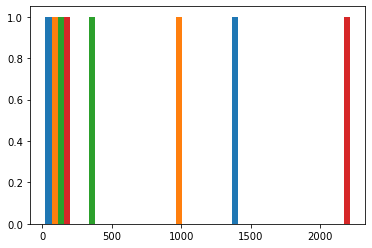

In [62]:
from matplotlib import pyplot as plt
plt.hist(bunching_distribution.items())


These numbers have been used on 300 samples for certification - see our article on Perceval for more details.

## Boson sampling with non perfect sources

Let us explore around performing Boson sampling with a non perfect source. We declare a source with 90% brightness and purity. Here, we would reach the limits of the simulation if we use the same input as before, as for each photon at the entrance, we multiply by 3 the number of input states (0, 1 or 2 photons at the input), leading to $3^n$ states.

In [20]:
3 ** n

27

In [21]:
source = pcvl.Source(brightness=0.90, purity=0.9)
QPU = pcvl.Processor("CliffordClifford2017", Linear_Circuit_60, source)
QPU.with_input(pcvl.BasicState([0, 1, 1] + (m - 3) * [0]))

We can see what is the source distribution, so how likely a state at the input of the linear circuit will be.

In [28]:
pcvl.pdisplay(QPU.source_distribution, precision=1e-7, max_v=20)

state,probability
"|0,1,1,0>",0.6561
"|0,0,1,0>",0.081
"|0,1,0,0>",0.081
"|0,2,1,0>",0.0729
"|0,1,2,0>",0.0729
"|0,0,0,0>",0.01
"|0,0,2,0>",0.009
"|0,2,0,0>",0.009
"|0,2,2,0>",0.0081


In [47]:
pcvl.pdisplay_to_file()

TypeError: pdisplay_to_file() missing 2 required positional arguments: 'o' and 'path'

Now we can launch again starting from cell 8 to use this imperfect QPU with the same nominal input, or from cell 7 for another random input.

[1]: Hui Wang, et al. Boson Sampling with 20 Input Photons and a 60-Mode Interferometer in a $10^{14}$-Dimensional Hilbert Space. [Physical Review Letters](https://link.aps.org/doi/10.1103/PhysRevLett.123.250503), 123(25):250503, December 2019. Publisher: American Physical Society.

[2]: Michael Reck, Anton Zeilinger, Herbert J Bernstein, and Philip Bertani. Experimental realization of any discrete unitary operator. [Physical review letters](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.73.58), 73(1):58, 1994.